In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sd3_pipeline import SD3CNPipeline
from sd3 import SD3CNModel, get_sigmas
from diffusers import AutoencoderKL, FlowMatchEulerDiscreteScheduler
import torch
import numpy as np
from controlnext import ControlNeXtModel
import copy

2024-11-14 18:00:01.614117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 18:00:01.614167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 18:00:01.615323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 18:00:01.621708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 18:00:02.493505: W tensorflow/compiler/tf2

In [3]:
from text_embed import encode_prompt, get_precomputed_tensors
from diffusers.training_utils import compute_density_for_timestep_sampling, compute_loss_weighting_for_sd3
import matplotlib.pyplot as plt
import torchvision

In [4]:
device = 'cuda:0'

In [5]:
vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-3-medium",
            subfolder="vae",
            revision="refs/pr/26").to(device)

In [8]:
tensor_list = get_precomputed_tensors(device=device)
        
pixel_list = [x['img'] for x in tensor_list]
hint_list = [x['hint'] for x in tensor_list]
prompt_embed_list = [x['prompt_embeds'] for x in tensor_list]
pooled_prompt_embed_list = [x['pooled_prompt_embeds'] for x in tensor_list]

index = 0
pixel_values = pixel_list[index].to(device)
hint_values = hint_list[index].to(device)
prompt_embeds = prompt_embed_list[index].to(device)
pooled_prompt_embeds = pooled_prompt_embed_list[index].to(device)
print(tensor_list[index]['prompt'])



pale golden rod circle with old lace background


In [7]:
resize = torchvision.transforms.Resize((1024,1024))
pixel_values2 = resize(pixel_values)
hint_values2 = resize(hint_values)

/home/sj/mambaforge/envs/py3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
hint_values.shape, hint_values2.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 1024, 1024]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 16, 64, 64]) torch.Size([1, 3, 512, 512])


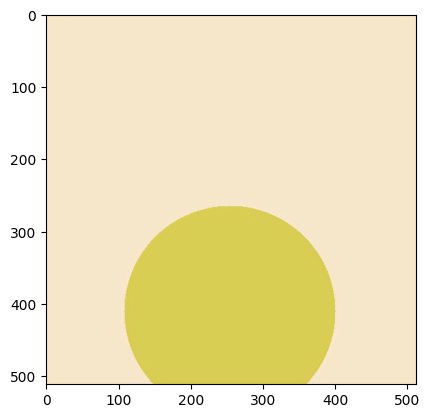

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


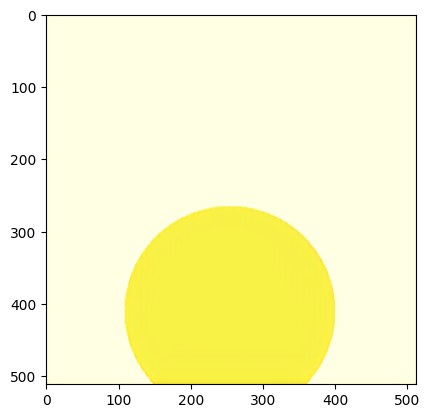

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


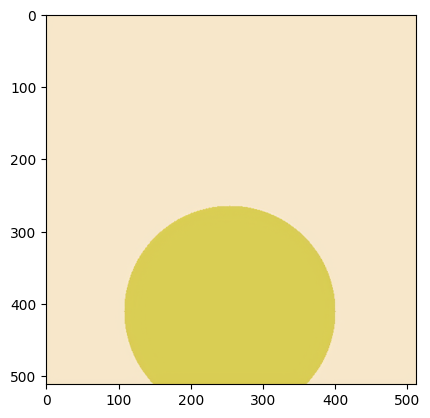

In [12]:
e1 = vae.encode(pixel_values).latent_dist.sample()
e1_scaled = (e1 - vae.config.shift_factor) * vae.config.scaling_factor
e1_descaled = e1_scaled / vae.config.scaling_factor + vae.config.shift_factor
d1 = vae.decode(e1, return_dict=False)[0]
d1_scaled = vae.decode(e1_scaled, return_dict=False)[0]
d1_descaled = vae.decode(e1_descaled, return_dict=False)[0]

print(e1.shape, d1.shape)
res1 = d1.squeeze().cpu().detach().permute(1,2,0).numpy()
res1_scaled = d1_scaled.squeeze().cpu().detach().permute(1,2,0).numpy()
res1_descaled = d1_descaled.squeeze().cpu().detach().permute(1,2,0).numpy()

plt.imshow(res1)
plt.show()
plt.imshow(res1_scaled)
plt.show()
plt.imshow(res1_descaled)
plt.show()

# e2 = vae.encode(hint_values2).latent_dist.sample()
# d2 = vae.decode(e2, return_dict=False)[0]
# print(e2.shape, d2.shape)
# res2 = d2.squeeze().cpu().detach().permute(1,2,0).numpy()

# plt.imshow(res2)

In [14]:
from diffusers.utils.torch_utils import randn_tensor

In [61]:
t1 = randn_tensor((1, 3, 512, 512)).to(device)
t2 = randn_tensor((1, 3, 128, 128)).to(device)

In [ ]:
resize = torchvision.transforms.Resize((1024,1024))
t3 = resize(t1)

In [70]:
512/64

8.0

In [85]:
res1 = vae.encode(t1)
res2 = vae.encode(t2)
res3 = vae.encode(t3)

In [87]:
print(res1.latent_dist.sample().shape)
print(res2.latent_dist.sample().shape)
print(res3.latent_dist.sample().shape)

torch.Size([1, 16, 64, 64])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 128, 128])


In [76]:
import torchvision

In [69]:
print(res1.latent_dist.sample().shape)
print(res2.latent_dist.sample().shape)

torch.Size([1, 16, 64, 64])
torch.Size([1, 16, 16, 16])


In [89]:
import torch.nn as nn